In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
#import functions as fun

In [2]:
#mods = fun.models()
mods = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [30]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .01
mpl.rcParams['figure.subplot.top']    = .99
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .99
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .01
mpl.rcParams['figure.figsize']        = 7,4


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [29]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

#Get fingerprints
with xr.open_dataset('../rawdata/fp_uniform/AIS.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = ds['rsl'].values
with xr.open_dataset('../rawdata/fp_uniform/GrIS.nc') as ds:
    fp05_gr = ds['rsl'].values
fp05_gl = np.zeros((19,len(lat05),len(lon05)))
for r in range(1,20):
    with xr.open_dataset(f'../rawdata/fp_uniform/RGI_{r}.nc') as ds:
        fp05_gl[r-1,:,:] = ds['rsl'].values

#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))
fp_gr = np.zeros((len(lat),len(lon)))
fp_gl = np.zeros((19,len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]
        fp_gr[i,j] = fp05_gr[ig,jg]
        fp_gl[:,i,j] = fp05_gl[:,ig,jg]

In [22]:
def get_mms(scen):
    with xr.open_dataset(f'../data/rsl/{mods[0]}_{scen}.nc') as ds:
        lon = ds['lon'].values
        lat = ds['lat'].values
    mm = np.zeros((len(mods),len(lat),len(lon)))

    for m,model in enumerate(mods):
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            stdn = np.nanmean(ds['stdn'][-20:,:,:].values,axis=0)
            glac = np.nanmean(ds['glac'][-20:,:,:].values,axis=0)
            gsmb = np.nanmean(ds['gsmb'][-20:,:,:].values,axis=0)
            asmb = np.nanmean(ds['asmb'][-20:,:,:].values,axis=0)
            adyn = np.nanmean(ds['adyn'][-20:,:,:].values,axis=0)
            
            mm[m,:,:] = stdn+glac+gsmb+asmb+adyn

    mms = np.nanvar(mm,axis=0)
    mms[np.isnan(slr_md)]=np.nan
    return mms

In [23]:
def sig(var):
    return np.std(var,axis=0)

In [24]:
def get_refcov(scen):
    stdn = np.zeros((len(mods),len(lat),len(lon)))
    adyn = np.zeros((len(mods),len(lat),len(lon)))
    asmb = np.zeros((len(mods),len(lat),len(lon)))
    gsmb = np.zeros((len(mods),len(lat),len(lon)))
    glac = np.zeros((len(mods),len(lat),len(lon)))

    for m,model in enumerate(mods):

        #Get zos
        file = f'../rawdata/zos/CorrectedZOS_EXP{scen}_{model}.nc'
        with xr.open_dataset(file) as ds:
            zos = np.nanmean(ds['CorrectedZOS_reg'][-20:,:,:].values,axis=0)

        #Add steric expansion    
        with xr.open_dataset(f'../data/steric/{model}_{scen}.nc') as ds:
            ster = np.nanmean(ds['SLR'][-20:].values)
        stdn[m,:,:] = zos+ster
            
        #Add Antarctic dyn
        with xr.open_dataset(f'../data/Adyn/{model}_{scen}.nc') as ds:
            adyn[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a

        #Add Antarctic smb
        with xr.open_dataset(f'../data/Asmb/{model}_{scen}.nc') as ds:
            asmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a     

        #Add Greenland smb
        with xr.open_dataset(f'../data/Gsmb/{model}_{scen}.nc') as ds:  
            gsmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_gr

        #Add glaciers
        for r in range(1,20):
            with xr.open_dataset(f'../data/glacier/{model}_{scen}_{r}.nc') as ds:
                glac[m,:,:] += np.nanmean(ds['SLR'][-20:].values)*fp_gl[r-1,:,:]
        
    srocc = ((sig(stdn)+sig(asmb)+sig(gsmb))**2+sig(glac)**2+sig(adyn)**2)
    srocc[np.isnan(slr_md)]=np.nan
    
    nocov = (sig(stdn)**2+sig(glac)**2+sig(gsmb)**2+sig(asmb)**2+sig(adyn)**2)
    nocov[np.isnan(slr_md)]=np.nan
    
    fulcov = ((sig(stdn)+sig(glac)+sig(gsmb)+sig(asmb)+sig(adyn))**2)
    return srocc,nocov,fulcov

In [25]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Degrees of freedom <= 0 for slice.


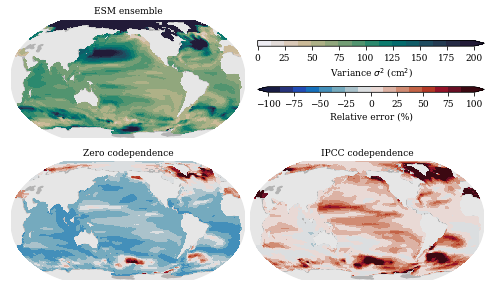

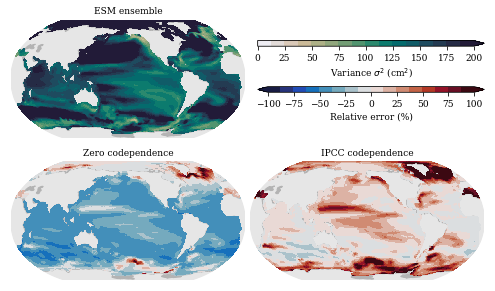

In [38]:
#cmap1 = plt.get_cmap('cmo.speed',16)
cmap1 = plt.get_cmap('cmo.rain',16)
cmap2 = plt.get_cmap('cmo.balance',16)
vmax1 = 200
vmax2 = 100

for s,scen in enumerate(['rcp45','rcp85']):

    fig = plt.figure()
    
    mm = get_mms(scen)
    sr,nc,fc = get_refcov(scen)
    
    ax = fig.add_subplot(2,2,1,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,mm,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax1,cmap=cmap1)
    makeglobal(ax)
    ax.set_title('ESM ensemble')
    
    ax = fig.add_subplot(2,2,3,projection=ccrs.Robinson(central_longitude=200))
#    im = ax.pcolormesh(lon,lat,nc,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax1,cmap=cmap1)    
    im2 = ax.pcolormesh(lon,lat,100*(nc-mm)/mm,transform=ccrs.PlateCarree(),vmin=-vmax2,vmax=vmax2,cmap=cmap2)
    makeglobal(ax)
    ax.set_title('Zero codependence')
    
    ax = fig.add_subplot(2,2,4,projection=ccrs.Robinson(central_longitude=200))
#    im = ax.pcolormesh(lon,lat,sr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax1,cmap=cmap1) 
    im2 = ax.pcolormesh(lon,lat,100*(sr-mm)/mm,transform=ccrs.PlateCarree(),vmin=-vmax2,vmax=vmax2,cmap=cmap2)
    makeglobal(ax)
    ax.set_title('IPCC codependence')
    
#    ax = fig.add_subplot(2,3,6,projection=ccrs.Robinson(central_longitude=200))
#    im = ax.pcolormesh(lon,lat,fc,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax1,cmap=cmap1) 
#    im2 = ax.pcolormesh(lon,lat,fc-mm,transform=ccrs.PlateCarree(),vmin=-vmax2,vmax=vmax2,cmap=cmap2)
#    makeglobal(ax)
#    ax.set_title('$\gamma = 1$')

    cax = fig.add_axes([.54,.86,.45,.02])
    cb = plt.colorbar(im,cax=cax,extend='max',orientation='horizontal')
    cb.set_label('Variance $\sigma^2$ (cm$^2$)')

    cax = fig.add_axes([.54,.7,.45,.02])
    cb = plt.colorbar(im2,cax=cax,extend='both',orientation='horizontal')
    cb.set_label('Relative error (%)')

    figname = f'draftplot_regvar_{scen}.png'

    plt.savefig(f'../figures/{figname}',dpi=200)
    plt.savefig(f'../../../writing/codependence/figures/{figname}')
    plt.show()
    plt.close()